In [2]:
#starting out with image segmentation
import datetime
import os

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Flatten, Dense, Reshape, Conv2D, MaxPool2D, Conv2DTranspose)

import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'Greys_r'
'''
This line of code sets the default colormap for matplotlib plots to "Greys_r",
which is a grayscale colormap in reverse. 
In other words, it sets the color map used to represent image data to a grayscale 
scheme where darker values are represented by lighter shades and vice versa.
'''

'\nThis line of code sets the default colormap for matplotlib plots to "Greys_r",\nwhich is a grayscale colormap in reverse. \nIn other words, it sets the color map used to represent image data to a grayscale \nscheme where darker values are represented by lighter shades and vice versa.\n'

# data preprocessing

In [4]:
# loading the training and test sets from TFRecords
raw_training_dataset = tf.data.TFRecordDataset('data/train_images.tfrecords')
raw_val_dataset      = tf.data.TFRecordDataset('data/val_images.tfrecords')

Data is already in `Tf record form`

In [5]:
print(raw_training_dataset)

<TFRecordDatasetV2 shapes: (), types: tf.string>


In [6]:
# dictionary describing the fields stored in TFRecord, and used to extract the date from the TFRecords
image_feature_description = {
    'height':    tf.io.FixedLenFeature([], tf.int64),
    'width':     tf.io.FixedLenFeature([], tf.int64),
    'depth':     tf.io.FixedLenFeature([], tf.int64),
    'name' :     tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'label_raw': tf.io.FixedLenFeature([], tf.string),
}

In [8]:
# helper function to extract an image from the dictionary
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_training_dataset = raw_training_dataset.map(_parse_image_function)
parsed_val_dataset      = raw_val_dataset.map(_parse_image_function)

In [11]:
print(str(len(list(parsed_training_dataset)))+" "+str(len(list(parsed_val_dataset))))

234 26


In [12]:
# function to read and decode an example from the parsed dataset
@tf.function
def read_and_decode(example):
    # Decode the raw image data from the example
    image_raw = tf.io.decode_raw(example['image_raw'], tf.int64)
    # Set the shape of the decoded image
    image_raw.set_shape([65536])  # 256x256 pixels * 1 channel = 65536
    # Reshape the image data to its original dimensions
    image = tf.reshape(image_raw, [256, 256, 1])

    # Convert the image data to float32 and normalize it
    image = tf.cast(image, tf.float32) * (1. / 1024)

    # Decode the raw label data from the example
    label_raw = tf.io.decode_raw(example['label_raw'], tf.uint8)
    # Set the shape of the decoded label
    label_raw.set_shape([65536])  # 256x256 pixels * 1 channel = 65536
    # Reshape the label data to its original dimensions
    label = tf.reshape(label_raw, [256, 256, 1])

    # Return the decoded and processed image and label
    return image, label


In [13]:
# get datasets read and decoded, and into a state usable by TensorFlow
tf_autotune = tf.data.experimental.AUTOTUNE
train = parsed_training_dataset.map(
    read_and_decode, num_parallel_calls=tf_autotune)
val = parsed_val_dataset.map(read_and_decode)
train.element_spec
#this essentially applies the read and decode to all the image samples

(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))

In [14]:
# setup the buffer size and batch size for data reading and training
BUFFER_SIZE = 10
BATCH_SIZE = 1

In [15]:
# setup the train and test data by shuffling, prefetching, etc
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf_autotune)
test_dataset  = val.batch(BATCH_SIZE)
train_dataset

<PrefetchDataset shapes: ((None, 256, 256, 1), (None, 256, 256, 1)), types: (tf.float32, tf.uint8)>

In [16]:
# helper function to display an image, it's label and the prediction
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'Label', 'Predicted Label']

    for i in range(len(display_list)):
        display_resized = tf.reshape(display_list[i], [256, 256])
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_resized)
        plt.axis('off')
    plt.show()

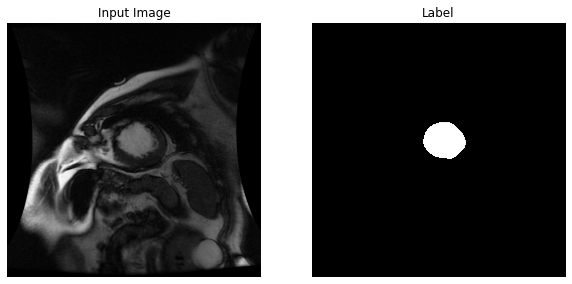

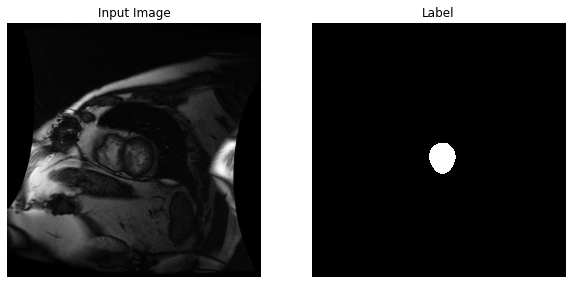

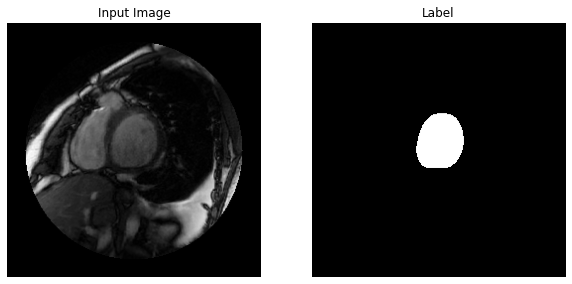

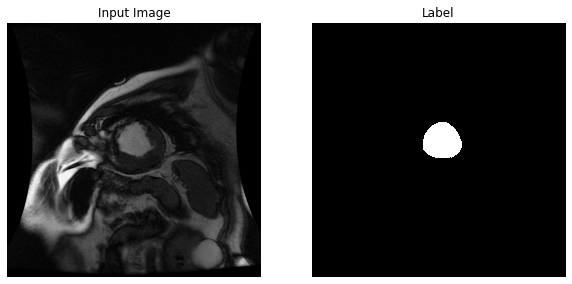

In [18]:
# display an image and label from the training set
for image, label in train.take(4):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

here label is the area marking the left ventrical and the image is crossection of heart from an mri machine

In [19]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    Flatten(input_shape=[256,256,1]),#256X256 and 1 colour chanel
    Dense(64,activation='relu'),#hidden layer with 64 neurons
    Dense(256*256*2,activation='softmax'),#Output layer but why use softmax??
    Reshape((256,256,2))
])#creating the neiral network


In [21]:
model.compile(
    optimizer='adam',#sgd + momentum + RMS
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4194368   
_________________________________________________________________
dense_1 (Dense)              (None, 131072)            8519680   
_________________________________________________________________
reshape (Reshape)            (None, 256, 256, 2)       0         
Total params: 12,714,048
Trainable params: 12,714,048
Non-trainable params: 0
_________________________________________________________________


just 12 million parameters where somthing lime llama has 7 billion parameters

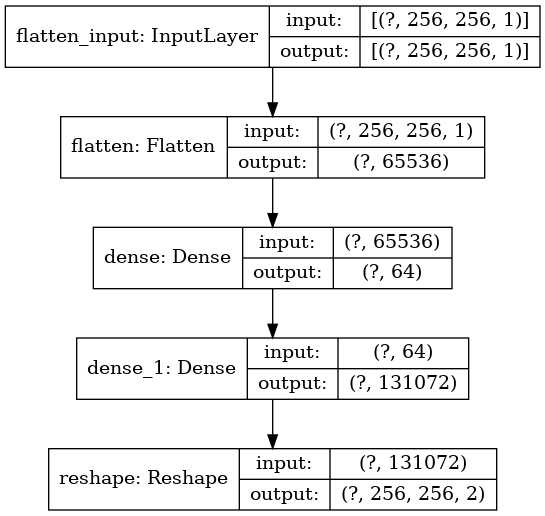

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

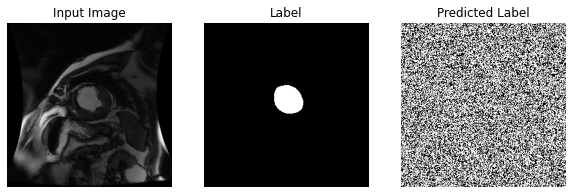

In [24]:
# function to take a prediction from the model and output an image for display
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]
# helper function to show the image, the label and the prediction
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, label in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], label[0], create_mask(pred_mask)])
    else:
        prediction = create_mask(model.predict(sample_image[tf.newaxis, ...]))
        display([sample_image, sample_label, prediction])
# show a predection, as an example
show_predictions(test_dataset)

random noise right now no training , just simple funtions to display when we are done

Next, we'll create our own custom [Keras Callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback), so that at the end of each epoch, we'll see what our model predicts on our `sample_image`. We'll also set up a [TensorBoard callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) so we can graph our training results.

In [26]:
# define a callback that shows image predictions on the test set
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# setup a tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

## Training the Model


In [28]:
#use common steps
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

Train for 234 steps, validate for 26 steps
Epoch 1/20
227/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5061

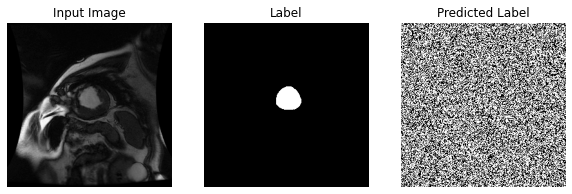


Sample Prediction after epoch 1

234/234 [==============================] - 3s 12ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6931 - val_accuracy: 0.5128
Epoch 2/20
232/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5209

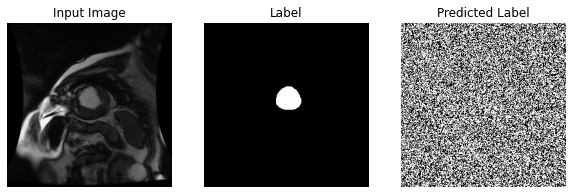


Sample Prediction after epoch 2

234/234 [==============================] - 2s 10ms/step - loss: 0.6931 - accuracy: 0.5210 - val_loss: 0.6931 - val_accuracy: 0.5303
Epoch 3/20
232/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5424

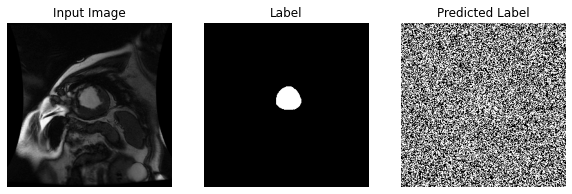


Sample Prediction after epoch 3

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.5426 - val_loss: 0.6931 - val_accuracy: 0.5582
Epoch 4/20
232/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5846

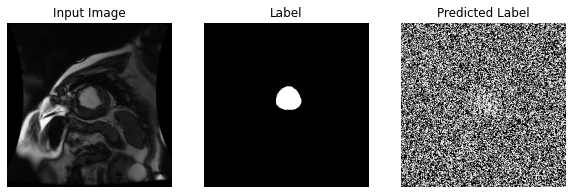


Sample Prediction after epoch 4

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.5849 - val_loss: 0.6931 - val_accuracy: 0.6215
Epoch 5/20
232/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.6856

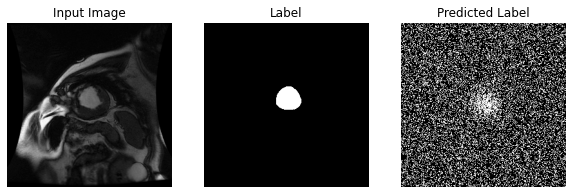


Sample Prediction after epoch 5

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.6863 - val_loss: 0.6931 - val_accuracy: 0.7709
Epoch 6/20
232/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.8747

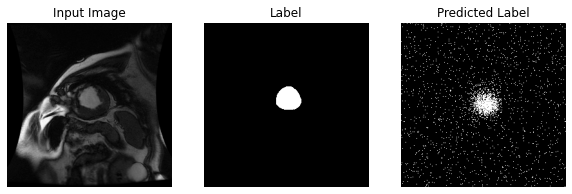


Sample Prediction after epoch 6

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.8755 - val_loss: 0.6931 - val_accuracy: 0.9639
Epoch 7/20
232/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9817

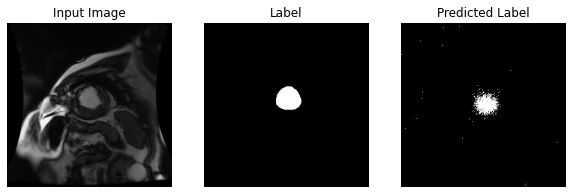


Sample Prediction after epoch 7

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9818 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 8/20
232/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9864

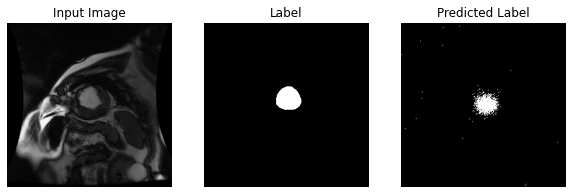


Sample Prediction after epoch 8

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9864 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 9/20
232/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9864

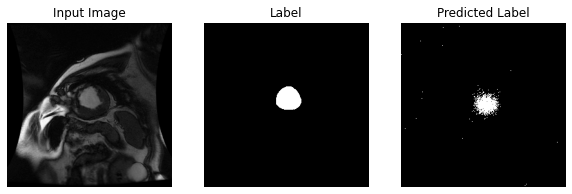


Sample Prediction after epoch 9

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9864 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 10/20
232/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9864

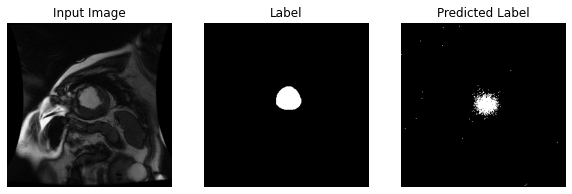


Sample Prediction after epoch 10

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9864 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 11/20
232/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9864

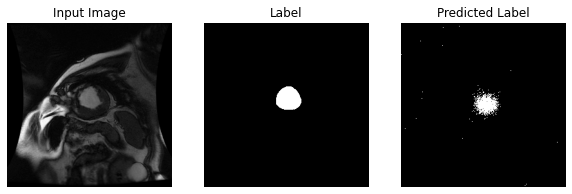


Sample Prediction after epoch 11

234/234 [==============================] - 2s 10ms/step - loss: 0.6931 - accuracy: 0.9864 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 12/20
232/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9864

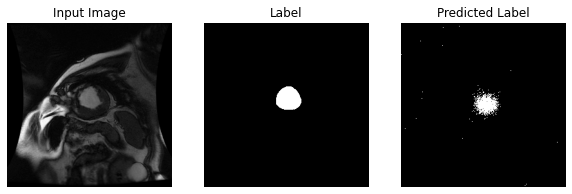


Sample Prediction after epoch 12

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9864 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 13/20
232/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9864

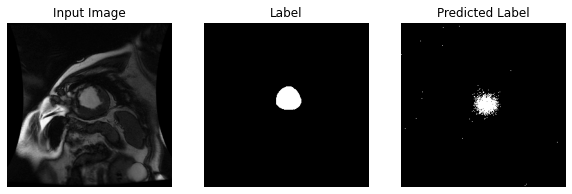


Sample Prediction after epoch 13

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9864 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 14/20
232/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9865

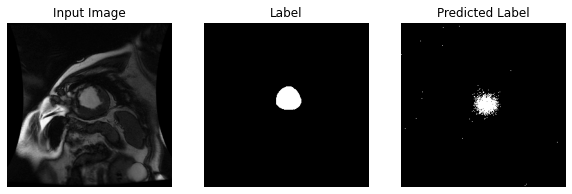


Sample Prediction after epoch 14

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9864 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 15/20
232/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9864

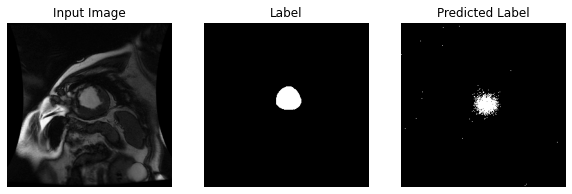


Sample Prediction after epoch 15

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9864 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 16/20
232/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9865

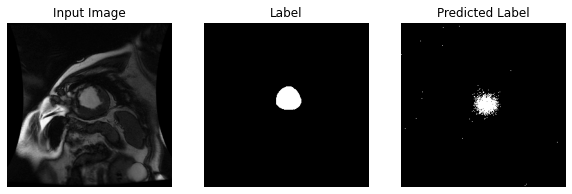


Sample Prediction after epoch 16

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9864 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 17/20
231/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9865

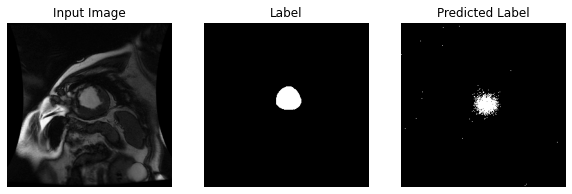


Sample Prediction after epoch 17

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9864 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 18/20
229/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9864

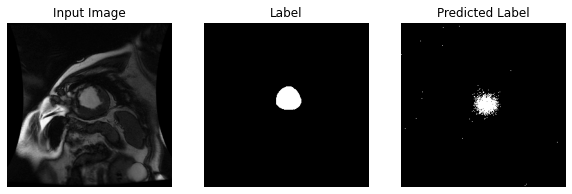


Sample Prediction after epoch 18

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9864 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 19/20
230/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9864

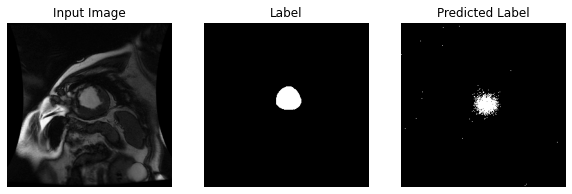


Sample Prediction after epoch 19

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9864 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 20/20
232/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9864

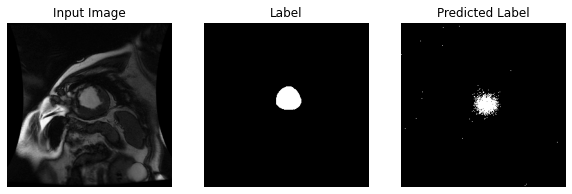


Sample Prediction after epoch 20

234/234 [==============================] - 2s 10ms/step - loss: 0.6931 - accuracy: 0.9864 - val_loss: 0.6931 - val_accuracy: 0.9865


In [29]:
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

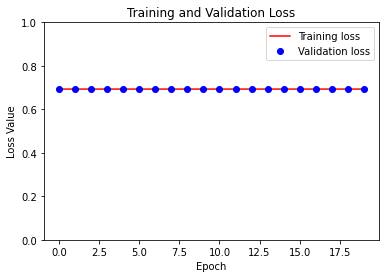

In [30]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


In [31]:
model.evaluate(test_dataset)

     26/Unknown - 0s 3ms/step - loss: 0.6931 - accuracy: 0.9865

[0.6931405067443848, 0.98646665]

# USING CNN 
the above model has learned the pixels which are common in all the sample images since the sample size is small and the placement is almost same simple nn just memorizes the positions that can mathc most of the traingn data
the above model is a very basic model just 3 layers , also it only tells indivisual pixels not regions for segmentiaon we need regions , for this well use Convolution layers which can capture larger receptive feilds

in cnn we also use pooling which down samples data while retaining most of the information . This elinimates some computation complexity
> CNN's are well-established as excellent choices for image recognition or classification tasks


In [32]:
tf.keras.backend.clear_session()

layers = [
    Conv2D(input_shape=[256, 256, 1],
           filters=100,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu,
           name="Conv1"),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=200,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=2,
           kernel_size=1,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2DTranspose(filters=2, kernel_size=31, strides=16, padding="same")
]

model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 128, 128, 100)     2600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 100)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 200)       500200    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 300)       540300    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 300)       810300    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 2)         6

significant recuction in trainable parameters which means faster training but also image segmentation since we are using cnn 

Train for 234 steps, validate for 26 steps
Epoch 1/20
232/234 [============================>.] - ETA: 0s - loss: 0.0884 - accuracy: 0.9688

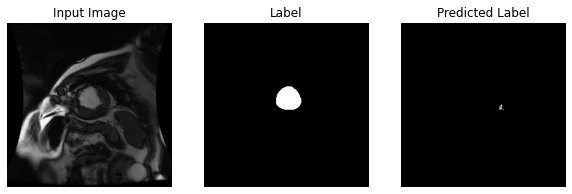


Sample Prediction after epoch 1

234/234 [==============================] - 5s 20ms/step - loss: 0.0880 - accuracy: 0.9689 - val_loss: 0.0521 - val_accuracy: 0.9829
Epoch 2/20
225/234 [===========================>..] - ETA: 0s - loss: 0.0372 - accuracy: 0.9837

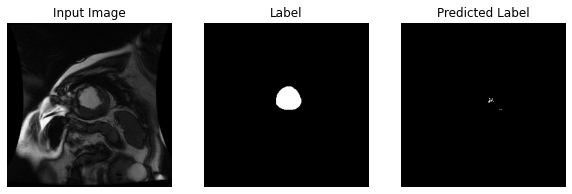


Sample Prediction after epoch 2

234/234 [==============================] - 2s 7ms/step - loss: 0.0369 - accuracy: 0.9838 - val_loss: 0.0393 - val_accuracy: 0.9832
Epoch 3/20
230/234 [============================>.] - ETA: 0s - loss: 0.0271 - accuracy: 0.9852

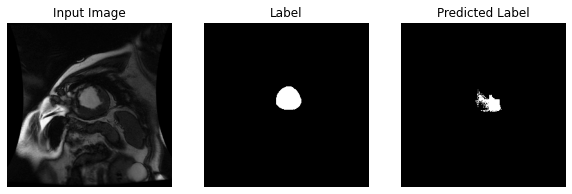


Sample Prediction after epoch 3

234/234 [==============================] - 2s 7ms/step - loss: 0.0271 - accuracy: 0.9853 - val_loss: 0.0247 - val_accuracy: 0.9880
Epoch 4/20
232/234 [============================>.] - ETA: 0s - loss: 0.0233 - accuracy: 0.9898

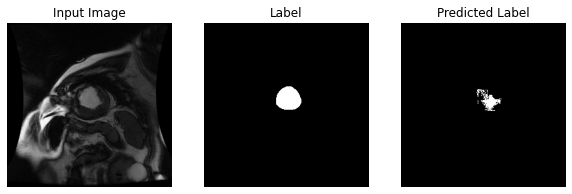


Sample Prediction after epoch 4

234/234 [==============================] - 2s 7ms/step - loss: 0.0233 - accuracy: 0.9897 - val_loss: 0.0227 - val_accuracy: 0.9893
Epoch 5/20
226/234 [===========================>..] - ETA: 0s - loss: 0.0192 - accuracy: 0.9921

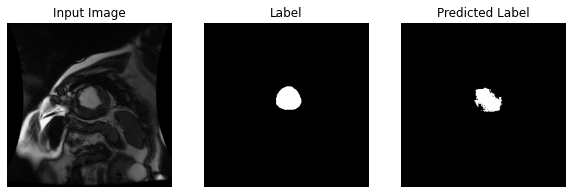


Sample Prediction after epoch 5

234/234 [==============================] - 2s 7ms/step - loss: 0.0193 - accuracy: 0.9920 - val_loss: 0.0198 - val_accuracy: 0.9921
Epoch 6/20
231/234 [============================>.] - ETA: 0s - loss: 0.0171 - accuracy: 0.9935

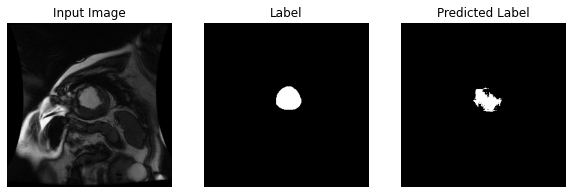


Sample Prediction after epoch 6

234/234 [==============================] - 2s 8ms/step - loss: 0.0172 - accuracy: 0.9934 - val_loss: 0.0183 - val_accuracy: 0.9920
Epoch 7/20
233/234 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9945

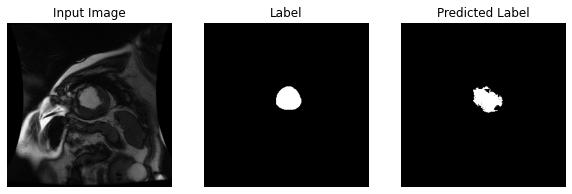


Sample Prediction after epoch 7

234/234 [==============================] - 2s 7ms/step - loss: 0.0150 - accuracy: 0.9945 - val_loss: 0.0172 - val_accuracy: 0.9936
Epoch 8/20
233/234 [============================>.] - ETA: 0s - loss: 0.0139 - accuracy: 0.9950

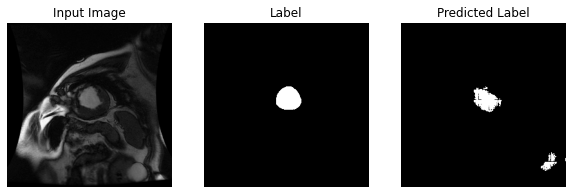


Sample Prediction after epoch 8

234/234 [==============================] - 2s 7ms/step - loss: 0.0138 - accuracy: 0.9950 - val_loss: 0.0276 - val_accuracy: 0.9886
Epoch 9/20
228/234 [============================>.] - ETA: 0s - loss: 0.0117 - accuracy: 0.9954

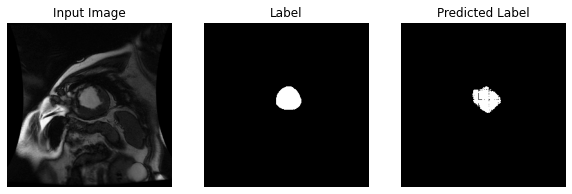


Sample Prediction after epoch 9

234/234 [==============================] - 2s 7ms/step - loss: 0.0117 - accuracy: 0.9954 - val_loss: 0.0156 - val_accuracy: 0.9941
Epoch 10/20
224/234 [===========================>..] - ETA: 0s - loss: 0.0106 - accuracy: 0.9958

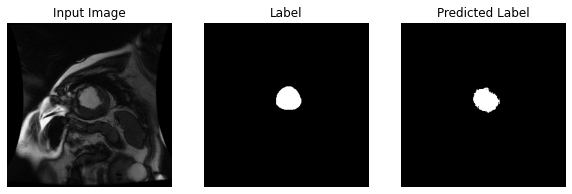


Sample Prediction after epoch 10

234/234 [==============================] - 2s 7ms/step - loss: 0.0105 - accuracy: 0.9958 - val_loss: 0.0130 - val_accuracy: 0.9954
Epoch 11/20
228/234 [============================>.] - ETA: 0s - loss: 0.0077 - accuracy: 0.9968

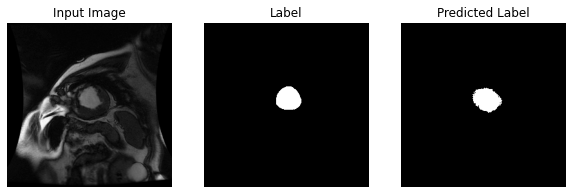


Sample Prediction after epoch 11

234/234 [==============================] - 2s 7ms/step - loss: 0.0076 - accuracy: 0.9969 - val_loss: 0.0109 - val_accuracy: 0.9960
Epoch 12/20
226/234 [===========================>..] - ETA: 0s - loss: 0.0060 - accuracy: 0.9975

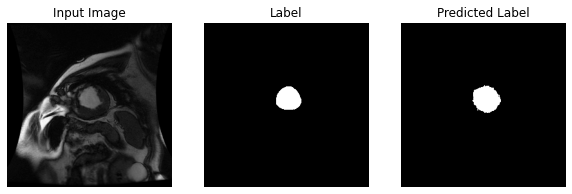


Sample Prediction after epoch 12

234/234 [==============================] - 2s 7ms/step - loss: 0.0061 - accuracy: 0.9974 - val_loss: 0.0092 - val_accuracy: 0.9964
Epoch 13/20
230/234 [============================>.] - ETA: 0s - loss: 0.0055 - accuracy: 0.9977

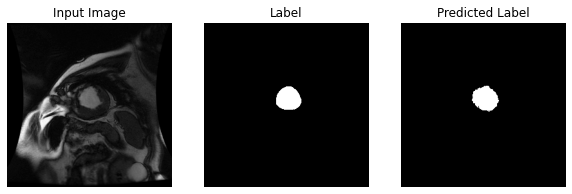


Sample Prediction after epoch 13

234/234 [==============================] - 2s 7ms/step - loss: 0.0055 - accuracy: 0.9977 - val_loss: 0.0121 - val_accuracy: 0.9962
Epoch 14/20
231/234 [============================>.] - ETA: 0s - loss: 0.0050 - accuracy: 0.9979

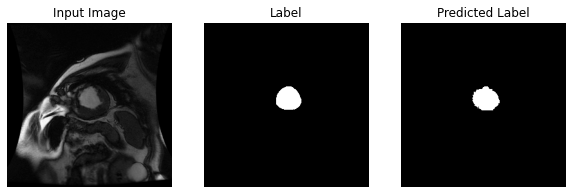


Sample Prediction after epoch 14

234/234 [==============================] - 2s 7ms/step - loss: 0.0050 - accuracy: 0.9979 - val_loss: 0.0115 - val_accuracy: 0.9965
Epoch 15/20
224/234 [===========================>..] - ETA: 0s - loss: 0.0043 - accuracy: 0.9982

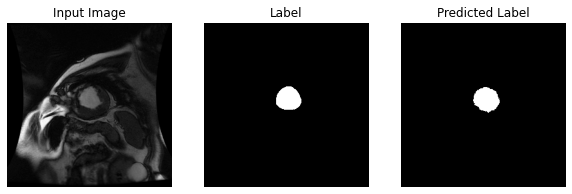


Sample Prediction after epoch 15

234/234 [==============================] - 2s 7ms/step - loss: 0.0043 - accuracy: 0.9982 - val_loss: 0.0100 - val_accuracy: 0.9968
Epoch 16/20
229/234 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.9982

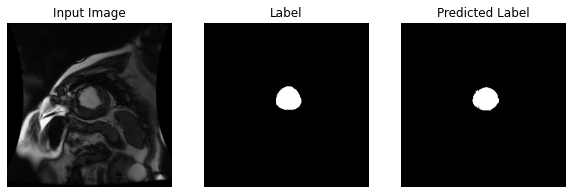


Sample Prediction after epoch 16

234/234 [==============================] - 2s 8ms/step - loss: 0.0042 - accuracy: 0.9982 - val_loss: 0.0102 - val_accuracy: 0.9968
Epoch 17/20
225/234 [===========================>..] - ETA: 0s - loss: 0.0040 - accuracy: 0.9983

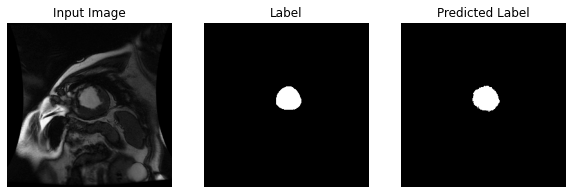


Sample Prediction after epoch 17

234/234 [==============================] - 2s 7ms/step - loss: 0.0040 - accuracy: 0.9983 - val_loss: 0.0087 - val_accuracy: 0.9968
Epoch 18/20
225/234 [===========================>..] - ETA: 0s - loss: 0.0043 - accuracy: 0.9982

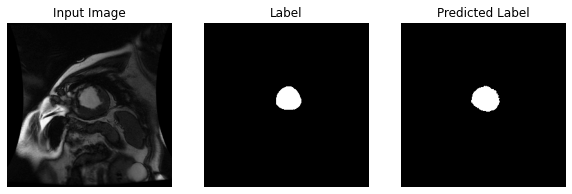


Sample Prediction after epoch 18

234/234 [==============================] - 2s 7ms/step - loss: 0.0042 - accuracy: 0.9982 - val_loss: 0.0084 - val_accuracy: 0.9969
Epoch 19/20
232/234 [============================>.] - ETA: 0s - loss: 0.0039 - accuracy: 0.9984

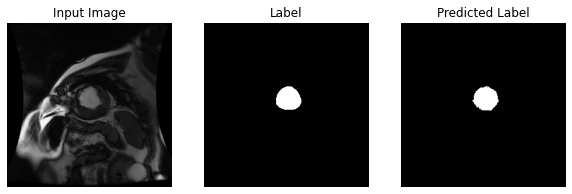


Sample Prediction after epoch 19

234/234 [==============================] - 2s 7ms/step - loss: 0.0039 - accuracy: 0.9984 - val_loss: 0.0099 - val_accuracy: 0.9969
Epoch 20/20
233/234 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.9983

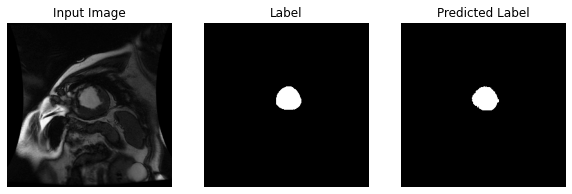


Sample Prediction after epoch 20

234/234 [==============================] - 2s 7ms/step - loss: 0.0040 - accuracy: 0.9983 - val_loss: 0.0079 - val_accuracy: 0.9971


In [34]:
# setup and run the model
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

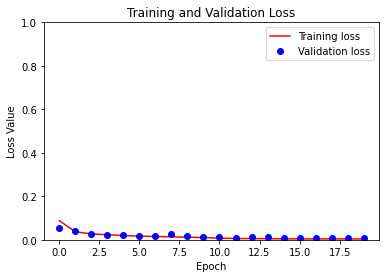

In [35]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Experimenting with diff models

## using less conv

In [46]:
tf.keras.backend.clear_session()

layers = [
    Conv2D(input_shape=[256, 256, 1],
           filters=100,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu,
           name="Conv1"),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=200,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=2,
           kernel_size=1,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2DTranspose(filters=2, kernel_size=31, strides=16, padding="same")
]

model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

Train for 234 steps, validate for 26 steps
Epoch 1/20
227/234 [============================>.] - ETA: 0s - loss: 0.1068 - accuracy: 0.9691

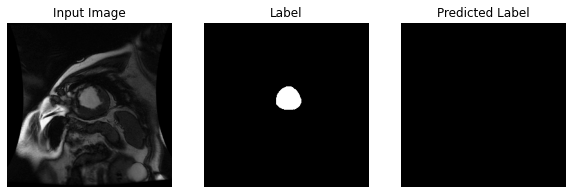


Sample Prediction after epoch 1

234/234 [==============================] - 2s 9ms/step - loss: 0.1052 - accuracy: 0.9695 - val_loss: 0.0566 - val_accuracy: 0.9830
Epoch 2/20
231/234 [============================>.] - ETA: 0s - loss: 0.0500 - accuracy: 0.9835

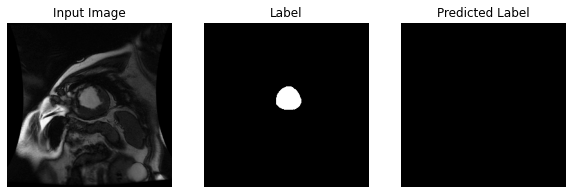


Sample Prediction after epoch 2

234/234 [==============================] - 2s 6ms/step - loss: 0.0498 - accuracy: 0.9836 - val_loss: 0.0482 - val_accuracy: 0.9830
Epoch 3/20
233/234 [============================>.] - ETA: 0s - loss: 0.0421 - accuracy: 0.9850

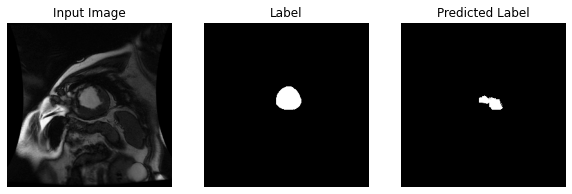


Sample Prediction after epoch 3

234/234 [==============================] - 2s 6ms/step - loss: 0.0421 - accuracy: 0.9850 - val_loss: 0.0397 - val_accuracy: 0.9878
Epoch 4/20
229/234 [============================>.] - ETA: 0s - loss: 0.0365 - accuracy: 0.9877

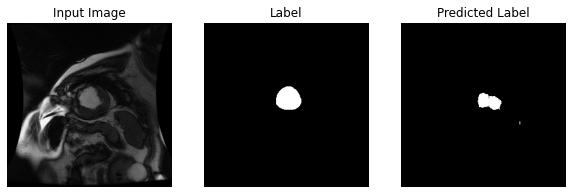


Sample Prediction after epoch 4

234/234 [==============================] - 1s 6ms/step - loss: 0.0362 - accuracy: 0.9877 - val_loss: 0.0302 - val_accuracy: 0.9903
Epoch 5/20
230/234 [============================>.] - ETA: 0s - loss: 0.0258 - accuracy: 0.9908

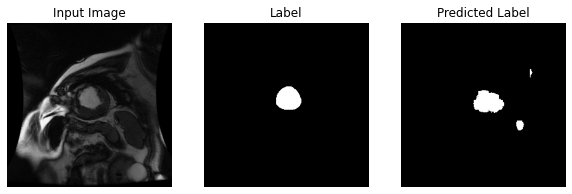


Sample Prediction after epoch 5

234/234 [==============================] - 1s 6ms/step - loss: 0.0256 - accuracy: 0.9909 - val_loss: 0.0254 - val_accuracy: 0.9912
Epoch 6/20
228/234 [============================>.] - ETA: 0s - loss: 0.0204 - accuracy: 0.9926

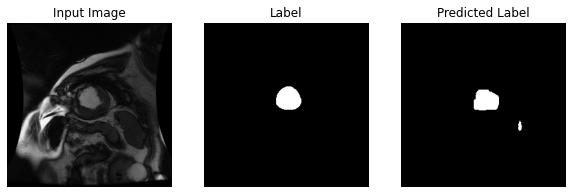


Sample Prediction after epoch 6

234/234 [==============================] - 1s 6ms/step - loss: 0.0203 - accuracy: 0.9927 - val_loss: 0.0185 - val_accuracy: 0.9938
Epoch 7/20
225/234 [===========================>..] - ETA: 0s - loss: 0.0171 - accuracy: 0.9937

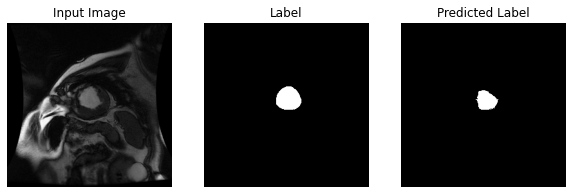


Sample Prediction after epoch 7

234/234 [==============================] - 2s 7ms/step - loss: 0.0171 - accuracy: 0.9937 - val_loss: 0.0277 - val_accuracy: 0.9912
Epoch 8/20
231/234 [============================>.] - ETA: 0s - loss: 0.0133 - accuracy: 0.9949

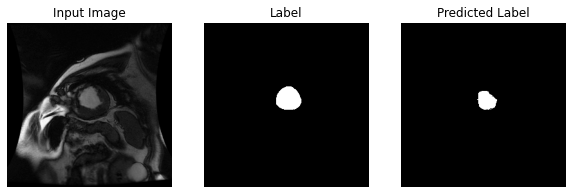


Sample Prediction after epoch 8

234/234 [==============================] - 1s 6ms/step - loss: 0.0133 - accuracy: 0.9949 - val_loss: 0.0307 - val_accuracy: 0.9900
Epoch 9/20
230/234 [============================>.] - ETA: 0s - loss: 0.0118 - accuracy: 0.9955

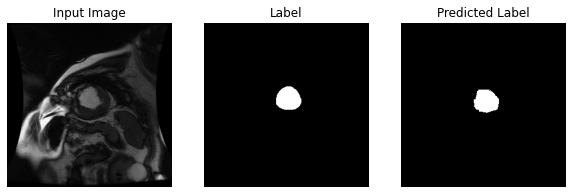


Sample Prediction after epoch 9

234/234 [==============================] - 2s 7ms/step - loss: 0.0118 - accuracy: 0.9955 - val_loss: 0.0140 - val_accuracy: 0.9949
Epoch 10/20
231/234 [============================>.] - ETA: 0s - loss: 0.0105 - accuracy: 0.9959

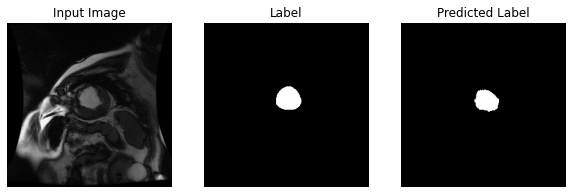


Sample Prediction after epoch 10

234/234 [==============================] - 1s 6ms/step - loss: 0.0105 - accuracy: 0.9959 - val_loss: 0.0153 - val_accuracy: 0.9946
Epoch 11/20
227/234 [============================>.] - ETA: 0s - loss: 0.0090 - accuracy: 0.9965

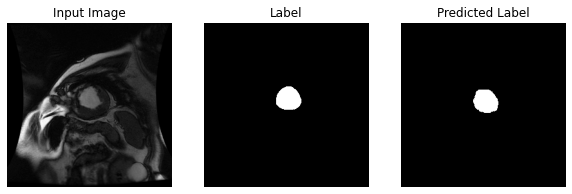


Sample Prediction after epoch 11

234/234 [==============================] - 1s 6ms/step - loss: 0.0090 - accuracy: 0.9965 - val_loss: 0.0120 - val_accuracy: 0.9957
Epoch 12/20
231/234 [============================>.] - ETA: 0s - loss: 0.0082 - accuracy: 0.9967

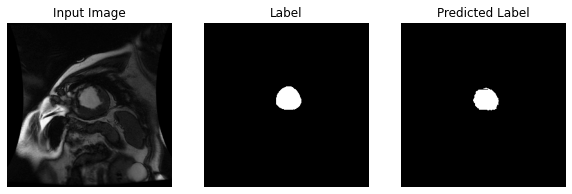


Sample Prediction after epoch 12

234/234 [==============================] - 1s 6ms/step - loss: 0.0081 - accuracy: 0.9967 - val_loss: 0.0108 - val_accuracy: 0.9959
Epoch 13/20
229/234 [============================>.] - ETA: 0s - loss: 0.0078 - accuracy: 0.9969

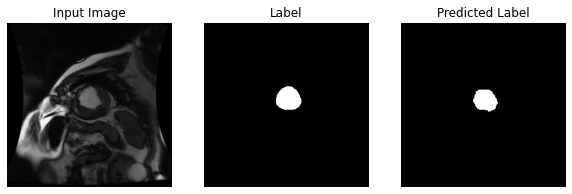


Sample Prediction after epoch 13

234/234 [==============================] - 1s 6ms/step - loss: 0.0078 - accuracy: 0.9969 - val_loss: 0.0133 - val_accuracy: 0.9952
Epoch 14/20
230/234 [============================>.] - ETA: 0s - loss: 0.0072 - accuracy: 0.9971

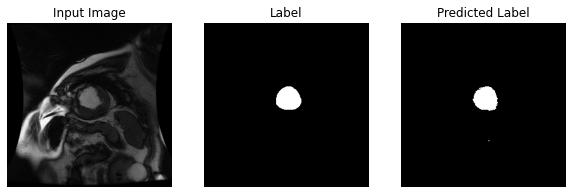


Sample Prediction after epoch 14

234/234 [==============================] - 1s 6ms/step - loss: 0.0072 - accuracy: 0.9971 - val_loss: 0.0113 - val_accuracy: 0.9957
Epoch 15/20
231/234 [============================>.] - ETA: 0s - loss: 0.0067 - accuracy: 0.9973

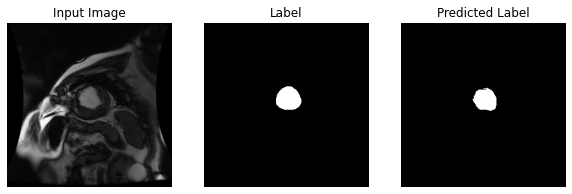


Sample Prediction after epoch 15

234/234 [==============================] - 2s 6ms/step - loss: 0.0067 - accuracy: 0.9973 - val_loss: 0.0127 - val_accuracy: 0.9954
Epoch 16/20
233/234 [============================>.] - ETA: 0s - loss: 0.0066 - accuracy: 0.9972

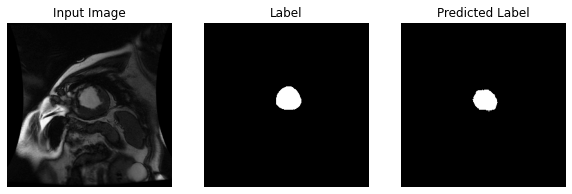


Sample Prediction after epoch 16

234/234 [==============================] - 1s 6ms/step - loss: 0.0066 - accuracy: 0.9973 - val_loss: 0.0139 - val_accuracy: 0.9949
Epoch 17/20
224/234 [===========================>..] - ETA: 0s - loss: 0.0058 - accuracy: 0.9976

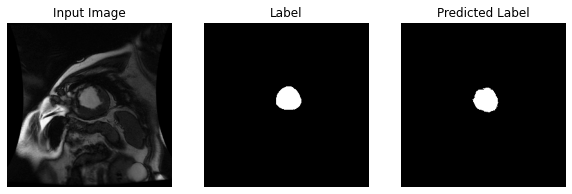


Sample Prediction after epoch 17

234/234 [==============================] - 2s 7ms/step - loss: 0.0059 - accuracy: 0.9975 - val_loss: 0.0102 - val_accuracy: 0.9961
Epoch 18/20
232/234 [============================>.] - ETA: 0s - loss: 0.0053 - accuracy: 0.9978

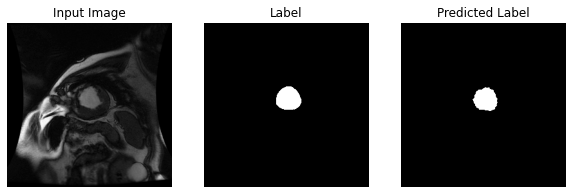


Sample Prediction after epoch 18

234/234 [==============================] - 1s 6ms/step - loss: 0.0053 - accuracy: 0.9978 - val_loss: 0.0107 - val_accuracy: 0.9964
Epoch 19/20
231/234 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 0.9980

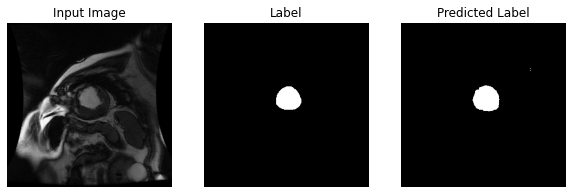


Sample Prediction after epoch 19

234/234 [==============================] - 1s 6ms/step - loss: 0.0049 - accuracy: 0.9980 - val_loss: 0.0128 - val_accuracy: 0.9955
Epoch 20/20
232/234 [============================>.] - ETA: 0s - loss: 0.0063 - accuracy: 0.9974

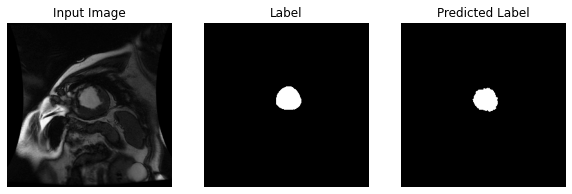


Sample Prediction after epoch 20

234/234 [==============================] - 1s 6ms/step - loss: 0.0063 - accuracy: 0.9974 - val_loss: 0.0103 - val_accuracy: 0.9964


In [47]:
#use common steps
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

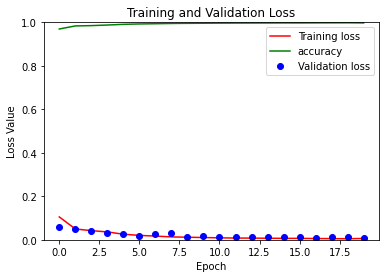

In [50]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, accuracy, 'g', label='accuracy')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## result : No discernable differnce 

# Conclusion

using simple nn with 1 hidden layer is ok but since this is a image segementaiton task rather than classification we need regiosn based rather than pixel base 

increasing number of hidden layers with varying num of neurons showed no imporvemnt

using less conv layers showed no improvement showing that using more conv decreases the compuational complexity while not causing any significant accuracy trade off

## OBVIOUSLY this all depends on many factors hence experimentaiton is required

# Next up: USING DICE factor to use as parameter